In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [8]:
"""
Things to add:
- plot on sequence of mixed strategy, to see if converge
- try different games to see how it does compared to literature
- 2x3 games with different info device
- 3x2 game with different info device
"""

'\nThings to add:\n- plot on sequence of mixed strategy, to see if converge\n- try different games to see how it does compared to literature\n- 2x3 games with different info device\n- 3x2 game with different info device\n'

# Algorithm definition

In [75]:
def q_learning(N, A, payoffs, T, alpha, beta0, k):
    """
    Q-learning algorithm for a finite simultaneous move game (2x2 example) with a plot of the sequence of play.

    Parameters:
        payoffs (list): A NxAxA list representing the payoff matrix.
                        payoffs[i][a] gives the payoff for player i for action profile a = (a[1],...,a[N])
                        when they choose action a_i and the opponent chooses action a_-i.
        T (int): Number of iterations.
        alpha (float): Q-value update parameter.
        beta (float): Softmax parameter for strategy computation

    Returns:
        dict: A dictionary containing:
              - Last iterate mixed strategies
              - Average mixed strategies
              - Frequency of play
              - Action history (sequence of actions chosen)
    """
    num_players = N
    num_actions = A

    # Initialize Q-values for both players
    Q = [np.zeros(num_actions) for _ in range(num_players)]

    # Track mixed strategies, action frequencies, and actions over time
    strategies = []
    action_counts = [np.zeros(num_actions) for _ in range(num_players)]
    action_history = [[] for _ in range(num_players)]

    for t in range(1, T + 1):
        mixed_strategies = []
        beta = beta0 + k*t
        
        # Compute mixed strategies using the softmax function 
        for i in range(num_players):
            Q_i = beta * Q[i]
            max_Q_i = np.max(Q_i)  # Get the max value to stabilize softmax
            mixed_strategy = np.exp(Q_i - max_Q_i)  # Subtract max to avoid overflow
            mixed_strategy /= np.sum(mixed_strategy)  # Normalize to sum to 1
            mixed_strategies.append(mixed_strategy)
        
        strategies.append(mixed_strategies)

        # Sample actions based on mixed strategies 
        actions = [np.random.choice(num_actions, p=mixed_strategies[i]) for i in range(num_players)]

        # Record actions
        for i in range(num_players):
            action_history[i].append(actions[i])

        # Update action counts
        for i in range(num_players):
            action_counts[i][actions[i]] += 1

        
        # PARTIAL FEEDBACK
#        """
        # Compute payoffs for the current actions
        rewards = [payoffs[i][tuple(actions)] for i in range(num_players)]

        # Update Q-values
        for i in range(num_players):
            Q[i][actions[i]] = (1-alpha) * Q[i][actions[i]] + rewards[i]
#        """

        # FULL FEEDBACK
        """
        # Compute payoffs for all actions of each player given the opponent's actions
        for i in range(num_players):
            opp_actions = actions[:i] + actions[i+1:]  # This is a list
            
            # Convert to tuple for correct concatenation
            opp_actions = tuple(opp_actions)
            
            # Loop through all possible actions of player i
            for a_i in range(A):
                # Construct the full action profile with current hypothetical action
                full_actions = opp_actions[:i] + (a_i,) + opp_actions[i:]
                
                # Get the reward for this action profile
                reward = payoffs[i][full_actions]
                
                # Update Q-value for this action
                Q[i][a_i] = (1 - alpha) * Q[i][a_i] + reward
        """
    
    # Compute average mixed strategies and action frequencies
    avg_mixed_strategies = np.mean(strategies, axis=0)
    frequencies = [counts / T for counts in action_counts]

    return {
        "last_iterate": mixed_strategies,
        "average_mixed_strategy": avg_mixed_strategies,
        "frequency_of_play": frequencies,
        "action_history": action_history,  # Include the sequence of actions for both players
        "strategy_history": strategies
    }

# Example: HD game

In [8]:
# Example 2x2 game payoffs (HD game):
"""
payoffs = [
    { (0, 0): 5, (0, 1): 1, (1, 0): 7, (1, 1): 0 },  # Payoffs for Player 0
    { (0, 0): 5, (0, 1): 7, (1, 0): 1, (1, 1): 0 }   # Payoffs for Player 1
]
"""

payoffs = [
    { (0, 0): 6, (0, 1): 4, (1, 0): 7, (1, 1): 0 },  # Payoffs for Player 0
    { (0, 0): 6, (0, 1): 7, (1, 0): 4, (1, 1): 0 }   # Payoffs for Player 1
]

In [10]:
payoffs,payoffs[1][(0,1)]

([{(0, 0): 6, (0, 1): 4, (1, 0): 7, (1, 1): 0},
  {(0, 0): 6, (0, 1): 7, (1, 0): 4, (1, 1): 0}],
 7)

In [27]:
# Parameters
N = 2
A = 2

T = 500
alpha = 0.5
beta = 0.01
k = 0.001

# gamma = 0.9

# Run Q-learning
results = q_learning(N, A, payoffs, T, alpha, beta, k)

# Display results
print("Last iterate mixed strategies:", results["last_iterate"])
print("Average mixed strategies:", results["average_mixed_strategy"])
print("Frequency of play:", results["frequency_of_play"])

Last iterate mixed strategies: [array([0.81285266, 0.18714734]), array([0.2669729, 0.7330271])]
Average mixed strategies: [[0.61102793 0.38897207]
 [0.57434235 0.42565765]]
Frequency of play: [array([0.62, 0.38]), array([0.562, 0.438])]


# Results

In [30]:
# Extract action history for both players
action_history_0 = results["action_history"][0]  # Player 0's action history
action_history_1 = results["action_history"][1]  # Player 1's action history

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = A  # Number of actions per player
frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0, action_history_1):
    frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

# The resulting frequency_matrix holds the counts of (Player 0 action, Player 1 action) pairs

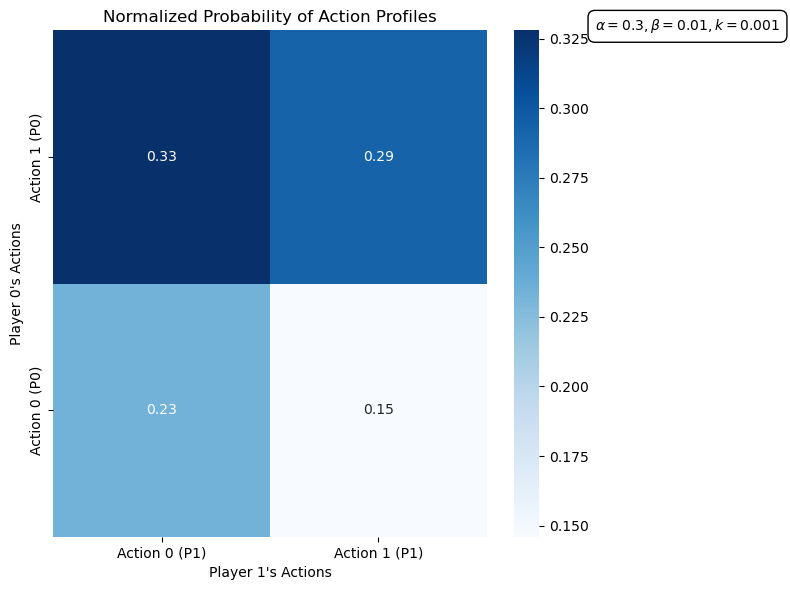

In [32]:
# Normalize the frequency matrix to get probabilities
frequency_matrix_prob = frequency_matrix / np.sum(frequency_matrix)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Normalized Probability of Action Profiles")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

# plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()

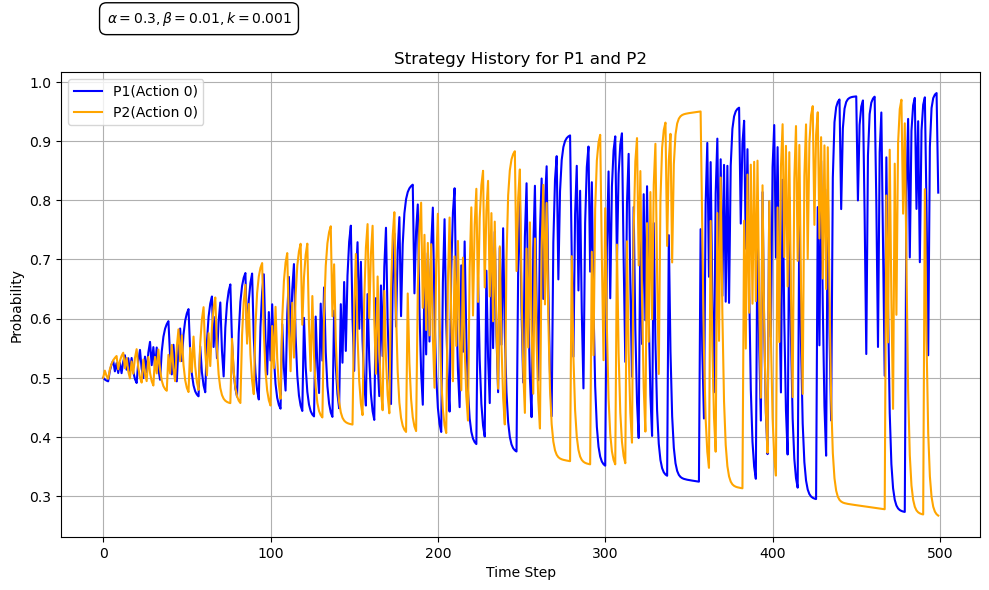

In [33]:
strategy_history = results["strategy_history"]

player_1_strategy_history = [step[0] for step in strategy_history]
player_2_strategy_history = [step[1] for step in strategy_history]

# Display the strategy history for Player 1
# print("Strategy history for Player 1:")
# for t, strategy in enumerate(player_1_strategy_history, start=1):
#     print(f"Step {t}: {strategy}")

prob_action_0_p1 = [strategy[0] for strategy in player_1_strategy_history]
prob_action_0_p2 = [strategy[0] for strategy in player_2_strategy_history]

# Plot the probabilities over time
plt.figure(figsize=(10, 6))
plt.plot(prob_action_0_p1, label="P1(Action 0)", color="blue")
plt.plot(prob_action_0_p2, label="P2(Action 0)", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.title("Strategy History for P1 and P2")
plt.legend()
plt.grid()

plt.text(
    2, 1.1,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

# plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/strategy_history_plot_PrisonerDilemma.png")

plt.show()

In [35]:
"""
epochs = 300  # Number of runs

# Collect results
all_results = {
    "last_iterate": [],
    "average_mixed_strategy": [],
    "frequency_of_play": []
}

for epoch in range(epochs):
    results = q_learning(N, A, payoffs, T, alpha, beta, k)
    
    all_results["last_iterate"].append(results["last_iterate"])
    all_results["average_mixed_strategy"].append(results["average_mixed_strategy"])
    all_results["frequency_of_play"].append(results["frequency_of_play"])
"""

'\nepochs = 300  # Number of runs\n\n# Collect results\nall_results = {\n    "last_iterate": [],\n    "average_mixed_strategy": [],\n    "frequency_of_play": []\n}\n\nfor epoch in range(epochs):\n    results = q_learning(N, A, payoffs, T, alpha, beta, k)\n    \n    all_results["last_iterate"].append(results["last_iterate"])\n    all_results["average_mixed_strategy"].append(results["average_mixed_strategy"])\n    all_results["frequency_of_play"].append(results["frequency_of_play"])\n'

Average Frequency Matrix over 300 epochs:
 [[0.33139333 0.26202667]
 [0.25694667 0.14963333]]


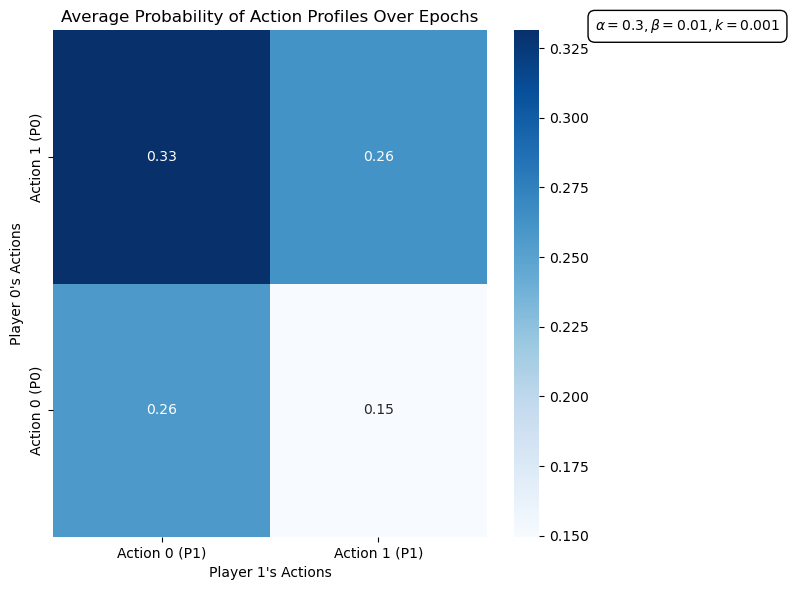

In [36]:
epochs = 300  # Number of runs

# Initialize the average frequency matrix
num_actions = A  # Number of actions per player
frequency_matrices = []

# Run over multiple epochs
for epoch in range(epochs):
    results = q_learning(N, A, payoffs, T, alpha, beta, k)

    # Extract action history for both players
    action_history_0 = results["action_history"][0]  # Player 0's action history
    action_history_1 = results["action_history"][1]  # Player 1's action history

    # Compute frequency matrix for this epoch
    frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

    # Count occurrences of each action profile
    for a0, a1 in zip(action_history_0, action_history_1):
        frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

    # Normalize by the number of time steps to get relative frequencies
    frequency_matrix = frequency_matrix / T

    # Store the frequency matrix for this epoch
    frequency_matrices.append(frequency_matrix)

# Compute final average over all epochs
average_frequency_matrix = np.mean(frequency_matrices, axis=0)

# Print the resulting matrix
print("Average Frequency Matrix over", epochs, "epochs:\n", average_frequency_matrix)

# Normalize the average frequency matrix to get probabilities
average_frequency_matrix_prob = average_frequency_matrix / np.sum(average_frequency_matrix)

# Plot the normalized average frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    average_frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Average Probability of Action Profiles Over Epochs")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

# Add parameter information
plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

# Save the figure if needed
# plt.savefig("/Users/franc/Dropbox/ML_project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()


In [39]:
# Define the target matrix

target_matrix_1 = np.array([
    [1, 0],
    [0, 0]
])


target_matrix_2 = np.array([
    [0, 1],
    [0, 0]
])


target_matrix_3 = np.array([
    [0, 0],
    [1, 0]
])


target_matrix_4 = np.array([
    [1/3, 1/3],
    [1/3, 0]
])

# Define tolerance
tolerance = 0.2

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices_1 = sum(
    matrix.shape == target_matrix_1.shape and np.all(np.abs(matrix - target_matrix_1) <= tolerance) 
    for matrix in frequency_matrices
)

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices_2 = sum(
    matrix.shape == target_matrix_2.shape and np.all(np.abs(matrix - target_matrix_2) <= tolerance) 
    for matrix in frequency_matrices
)

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices_3 = sum(
    matrix.shape == target_matrix_3.shape and np.all(np.abs(matrix - target_matrix_3) <= tolerance) 
    for matrix in frequency_matrices
)

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices_4 = sum(
    matrix.shape == target_matrix_4.shape and np.all(np.abs(matrix - target_matrix_4) <= tolerance) 
    for matrix in frequency_matrices
)

print(f"Number of matrices close to the target 1: {count_close_matrices_1}")
print(f"Number of matrices close to the target 2: {count_close_matrices_2}")
print(f"Number of matrices close to the target 3: {count_close_matrices_3}")
print(f"Number of matrices close to the target 4: {count_close_matrices_4}")

Number of matrices close to the target 1: 0
Number of matrices close to the target 2: 0
Number of matrices close to the target 3: 0
Number of matrices close to the target 4: 300


In [26]:
"""
- the simple heuristic shows that in HD game players seem to learn to play the welfare maximizing profile
- players learn to play action 1. In the long run, it is the welfare maximizing profile

- there is not really an issue of equilibrium selection in this specific game
- further research is required for more general classes of games, where explicit results are not present in the literature

- it is not a NE nor a CE of the stage game
- by the folk theorem, can be sustained as a NE of the repeated game
"""

average_frequency_matrix_prob

array([[0.371328  , 0.31627533],
       [0.30674533, 0.00565133]])

# Other examples: Prisoner Dilemma

In [80]:
# Example 2x2 game payoffs (PD game):

payoffs = [
    { (0, 0): 5, (0, 1): 1, (1, 0): 7, (1, 1): 2 },  # Payoffs for Player 0
    { (0, 0): 5, (0, 1): 7, (1, 0): 1, (1, 1): 2 }   # Payoffs for Player 1
]

"""
# Matching pennies
payoffs = [
    { (0, 0): 1, (0, 1): -1, (1, 0): -1, (1, 1): 1 },  # Payoffs for Player 0
    { (0, 0): -1, (0, 1): 1, (1, 0): 1, (1, 1): -1 }   # Payoffs for Player 1
]
"""

"""
# pick a game at random
payoffs = [
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1
]
"""

'\n# pick a game at random\npayoffs = [\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1\n]\n'

In [82]:
# Parameters
N = 2
A = 2

T = 1000
alpha = 0.3
beta = 0.01
k = 0.1

# gamma = 0.9

# Run Q-learning
results = q_learning(N, A, payoffs, T, alpha, beta, k)

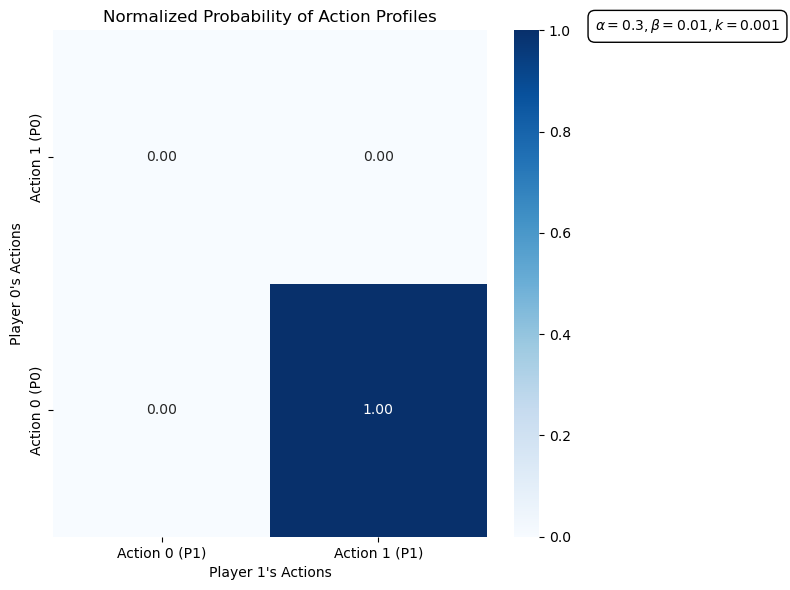

In [84]:
# Extract action history for both players
action_history_0 = results["action_history"][0]  # Player 0's action history
action_history_1 = results["action_history"][1]  # Player 1's action history

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = A  # Number of actions per player
frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0, action_history_1):
    frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

# The resulting frequency_matrix holds the counts of (Player 0 action, Player 1 action) pairs

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob = frequency_matrix / np.sum(frequency_matrix)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Normalized Probability of Action Profiles")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

# plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()

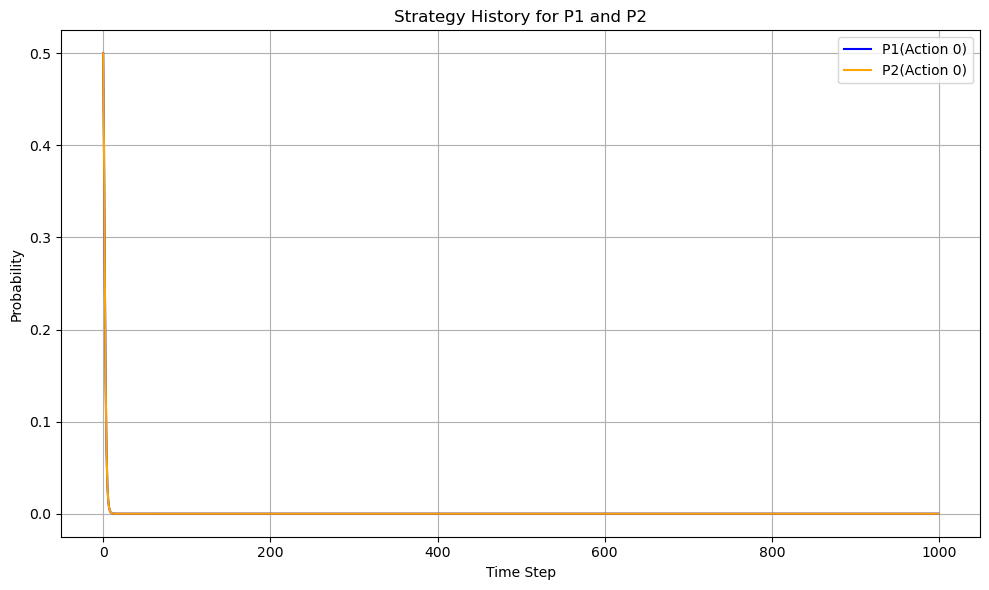

In [85]:
strategy_history = results["strategy_history"]

player_1_strategy_history = [step[0] for step in strategy_history]
player_2_strategy_history = [step[1] for step in strategy_history]

# Display the strategy history for Player 1
# print("Strategy history for Player 1:")
# for t, strategy in enumerate(player_1_strategy_history, start=1):
#     print(f"Step {t}: {strategy}")

prob_action_0_p1 = [strategy[0] for strategy in player_1_strategy_history]
prob_action_0_p2 = [strategy[0] for strategy in player_2_strategy_history]

# Plot the probabilities over time
plt.figure(figsize=(10, 6))
plt.plot(prob_action_0_p1, label="P1(Action 0)", color="blue")
plt.plot(prob_action_0_p2, label="P2(Action 0)", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.title("Strategy History for P1 and P2")
plt.legend()
plt.grid()

"""
plt.text(
    2, 1.1,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
"""

plt.tight_layout()

# plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/strategy_history_plot_PrisonerDilemma.png")

plt.show()

Average Frequency Matrix over 300 epochs:
 [[0.19010333 0.05788667]
 [0.06807667 0.68393333]]


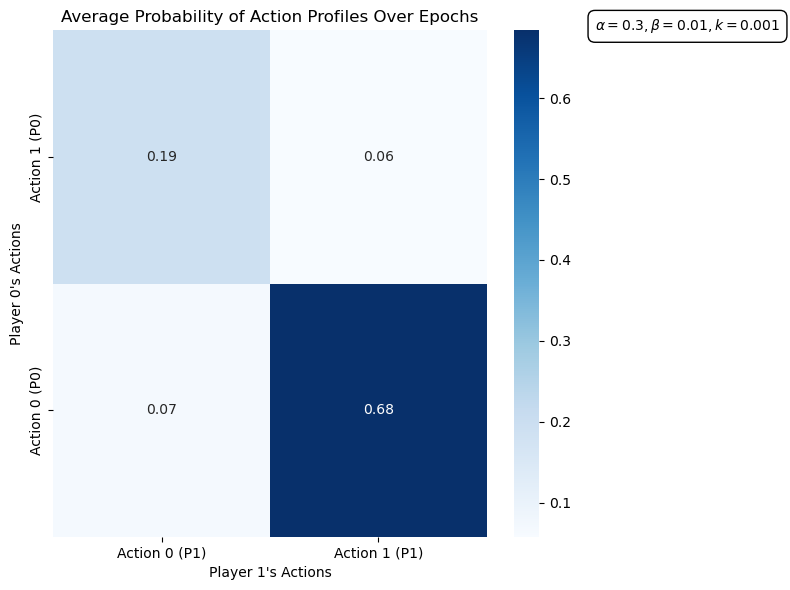

In [88]:
epochs = 300  # Number of runs

# Initialize the average frequency matrix
num_actions = A  # Number of actions per player
frequency_matrices = []

# Run over multiple epochs
for epoch in range(epochs):
    results = q_learning(N, A, payoffs, T, alpha, beta, k)

    # Extract action history for both players
    action_history_0 = results["action_history"][0]  # Player 0's action history
    action_history_1 = results["action_history"][1]  # Player 1's action history

    # Compute frequency matrix for this epoch
    frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

    # Count occurrences of each action profile
    for a0, a1 in zip(action_history_0, action_history_1):
        frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

    # Normalize by the number of time steps to get relative frequencies
    frequency_matrix = frequency_matrix / T

    # Store the frequency matrix for this epoch
    frequency_matrices.append(frequency_matrix)

# Compute final average over all epochs
average_frequency_matrix = np.mean(frequency_matrices, axis=0)

# Print the resulting matrix
print("Average Frequency Matrix over", epochs, "epochs:\n", average_frequency_matrix)

# Normalize the average frequency matrix to get probabilities
average_frequency_matrix_prob = average_frequency_matrix / np.sum(average_frequency_matrix)

# Plot the normalized average frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    average_frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Average Probability of Action Profiles Over Epochs")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

# Add parameter information
plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

# Save the figure if needed
# plt.savefig("/Users/franc/Dropbox/ML_project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()

In [51]:
# Define the target matrix

target_matrix = np.array([
    [0, 0],
    [0, 1]
])

# Define tolerance
tolerance = 0.2

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices = sum(
    matrix.shape == target_matrix.shape and np.all(np.abs(matrix - target_matrix) <= tolerance) 
    for matrix in frequency_matrices
)


print(f"Number of matrices close to the target 1: {count_close_matrices}")

Number of matrices close to the target 1: 0


# Other examples: 2x3 game

In [77]:
"""
payoffs = [
    { (0, 0): 0, (0, 1): 5, (0, 2): 1, (1, 0): 1, (1, 1): 0, (1, 2): 5, (2, 0): 5, (2, 1): 1, (2, 2): 0 },  # Payoffs for Player 0
    { (0, 0): 0, (0, 1): 1, (0, 2): 5, (1, 0): 5, (1, 1): 0, (1, 2): 1, (2, 0): 1, (2, 1): 5, (2, 2): 0 }   # Payoffs for Player 1
]
"""

"""
payoffs = [
    { (0, 0): 0, (0, 1): 3, (0, 2): 1, (1, 0): 1, (1, 1): 0, (1, 2): 3, (2, 0): 3, (2, 1): 1, (2, 2): 0 },  # Payoffs for Player 0
    { (0, 0): 0, (0, 1): 1, (0, 2): 3, (1, 0): 3, (1, 1): 0, (1, 2): 1, (2, 0): 1, (2, 1): 3, (2, 2): 0 }   # Payoffs for Player 1
]
"""

#"""
payoffs = [
    { (0, 0): 5, (0, 1): 0, (0, 2): 2, (1, 0): 0, (1, 1): 4, (1, 2): 3, (2, 0): 7, (2, 1): 0, (2, 2): 0 },  # Payoffs for Player 0
    { (0, 0): 5, (0, 1): 0, (0, 2): 7, (1, 0): 0, (1, 1): 4, (1, 2): 0, (2, 0): 2, (2, 1): 3, (2, 2): 0 }   # Payoffs for Player 1
]
#"""

In [79]:
# Parameters
N = 2
A = 3

T = 5000
alpha = 0.3
beta = 0.01
k = 0.001

# gamma = 0.9

# Run Q-learning
results = q_learning(N, A, payoffs, T, alpha, beta, k)

In [80]:
strategies = results["average_mixed_strategy"]
strategies

array([[0.01502944, 0.97251093, 0.01245964],
       [0.01324944, 0.96968167, 0.01706889]])

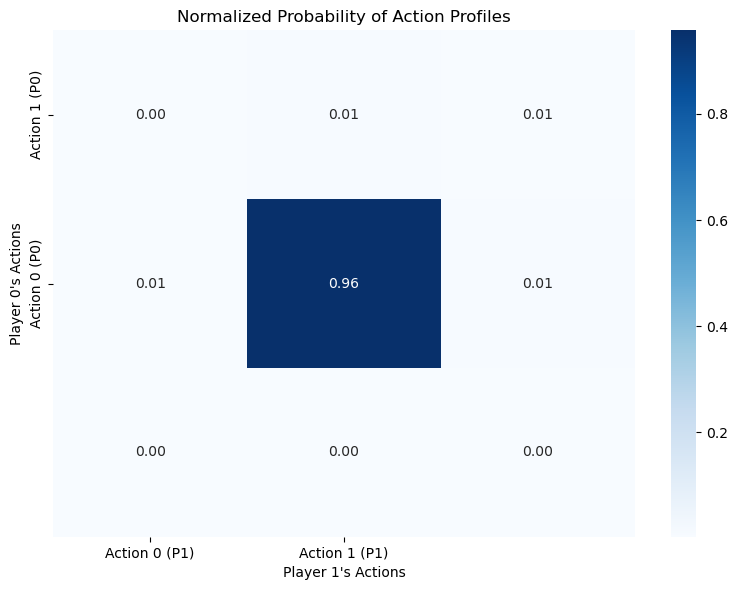

In [83]:
# Extract action history for both players
action_history_0 = results["action_history"][0]  # Player 0's action history
action_history_1 = results["action_history"][1]  # Player 1's action history

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = A  # Number of actions per player
frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0, action_history_1):
    frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

# The resulting frequency_matrix holds the counts of (Player 0 action, Player 1 action) pairs

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob = frequency_matrix / np.sum(frequency_matrix)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Normalized Probability of Action Profiles")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

"""
plt.text(
    3, -0.5,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
"""

plt.tight_layout()

# plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()

Average Frequency Matrix over 300 epochs:
 [[0.10101533 0.00660733 0.007524  ]
 [0.006582   0.85276867 0.00654533]
 [0.00726667 0.006426   0.00526467]]


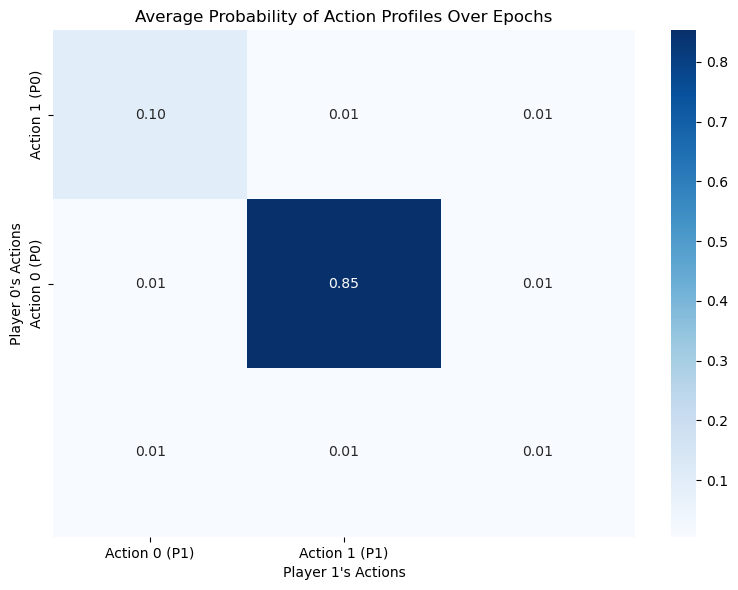

In [85]:
epochs = 300  # Number of runs

# Initialize the average frequency matrix
num_actions = A  # Number of actions per player
frequency_matrices = []

# Run over multiple epochs
for epoch in range(epochs):
    results = q_learning(N, A, payoffs, T, alpha, beta, k)

    # Extract action history for both players
    action_history_0 = results["action_history"][0]  # Player 0's action history
    action_history_1 = results["action_history"][1]  # Player 1's action history

    # Compute frequency matrix for this epoch
    frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

    # Count occurrences of each action profile
    for a0, a1 in zip(action_history_0, action_history_1):
        frequency_matrix[a0, a1] += 1  # Increment count for (a0, a1) profile

    # Normalize by the number of time steps to get relative frequencies
    frequency_matrix = frequency_matrix / T

    # Store the frequency matrix for this epoch
    frequency_matrices.append(frequency_matrix)

# Compute final average over all epochs
average_frequency_matrix = np.mean(frequency_matrices, axis=0)

# Print the resulting matrix
print("Average Frequency Matrix over", epochs, "epochs:\n", average_frequency_matrix)

# Normalize the average frequency matrix to get probabilities
average_frequency_matrix_prob = average_frequency_matrix / np.sum(average_frequency_matrix)

# Plot the normalized average frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    average_frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 1 (P0)", "Action 0 (P0)"]
)
plt.title("Average Probability of Action Profiles Over Epochs")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

# Add parameter information
"""
plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
"""

plt.tight_layout()

# Save the figure if needed
# plt.savefig("/Users/franc/Dropbox/ML_project/code/images_fra/frequency_PrisonerDilemma.png")

plt.show()

In [86]:
# Define the target matrix

target_matrix = np.array([
    [0, 1/6, 1/6],
    [1/6, 0, 1/6],
    [1/6, 1/6, 1/6]
])


# Define tolerance
tolerance = 0.2

# Count matrices that are close to the target matrix (only checking matrices with matching shape)
count_close_matrices = sum(
    matrix.shape == target_matrix.shape and np.all(np.abs(matrix - target_matrix) <= tolerance) 
    for matrix in frequency_matrices
)

print(f"Number of matrices close to the target 4: {count_close_matrices}")

Number of matrices close to the target 4: 0
